# MaskRCNN Challenge

*In this challenge you will be asked to build a deep learning solution capable of segmenting turtles on synthetic images. You will be provided with the data, which you can use to train your models; your best model will be used on a test image and you will be asked to implement some geometric algorithms based on the predictions of your model.*

***Training data***

The training data will consist of 30 256x256 images of the same synthetic turtle pasted on background images artificially generated by BigGAN (https://arxiv.org/abs/1809.11096).

Feel free to increase the dataset size as needed and make any relevant changes to the dataset creation.

Each image will come with the ground truth per-pixel segmentation mask which you can leverage for your training setup. You should try and use Instance Segmentation methods over Semantic Segmentation as Instance Segmentation can handle multiple classes and objects, and also can be used for counting individual occurences of these objects.

You are also allowed to use external data sources and pre-trained weights, but please provide justification if you choose to do so.


***Test data***

There will only be a single test image without the provided GT.

The test image differs from the training data and it is up to you to decide how to approach these differences. Notably, the test image is of resolution 512x512 and your predicted mask must be of the same resolution.


***Tasks***

1. Your main task is to build a deep learning model capable of accurately segmenting the turtle in the test image. Preferred choice: MaskRCNN
2. Based on the segmentation mask predicted by your model, you will need to implement an algorithm that finds a convex hull, i.e. a polygon enclosing all the foreground (i.e. turtle) pixels.
3. Implement an algorithm that calculates the area of the polygon from the result of task 2.


***Rules***

* While we provide all the code in PyTorch, feel free to use other deep learning frameworks as needed
* Feel free to use all the imported Python libraries
* For tasks 2 and 3 ***you are not allowed*** to use third-party functions that readily solve those tasks, e.g. you are not allowed to use various `cv2` and `scikit-image` operators. We expect the algorithms to be based on points and geometry rather than full-image operations.


***Submission***

* ***You must send us only a single link to the Colab notebook with your solution and nothing else!*** We should be able to reproduce your results by running the notebook. If you require additional files, use `gdown` to download them into the session storage (see Task 1 for details).
* Include your comments and explanations on the decisions that you made to approach the problem;
* Make sure to include the estimate of approximately how much time it took you to get to the final solution.

***Colab setup***

* To use GPU, go to `Runtime -> Change Runtime Type -> GPU`

In [1]:
# comment the following line if you are working outside of a notebook environment
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import random
from PIL import Image

In [2]:
# Used to download any files you need for your solution from Google Drive
import gdown
gdown.download("https://drive.google.com/uc?id=1ymKI8M73kBIck2b7S7QG02aiP4yXLaML", "turtle.png", quiet=False)

Downloading...
From: https://drive.google.com/uc?id=1ymKI8M73kBIck2b7S7QG02aiP4yXLaML
To: /home/shilpifire/Documents/Turtle_Segmentation/turtle.png
100%|██████████| 692k/692k [00:00<00:00, 4.18MB/s]


'turtle.png'

In [3]:
# read and visualise the turtle image
turtle_image = Image.open('./turtle.png')
# it is a 4-channel RGB+Alpha image of size 2394x1800
print(turtle_image.mode, turtle_image.size)

RGBA (2394, 1800)


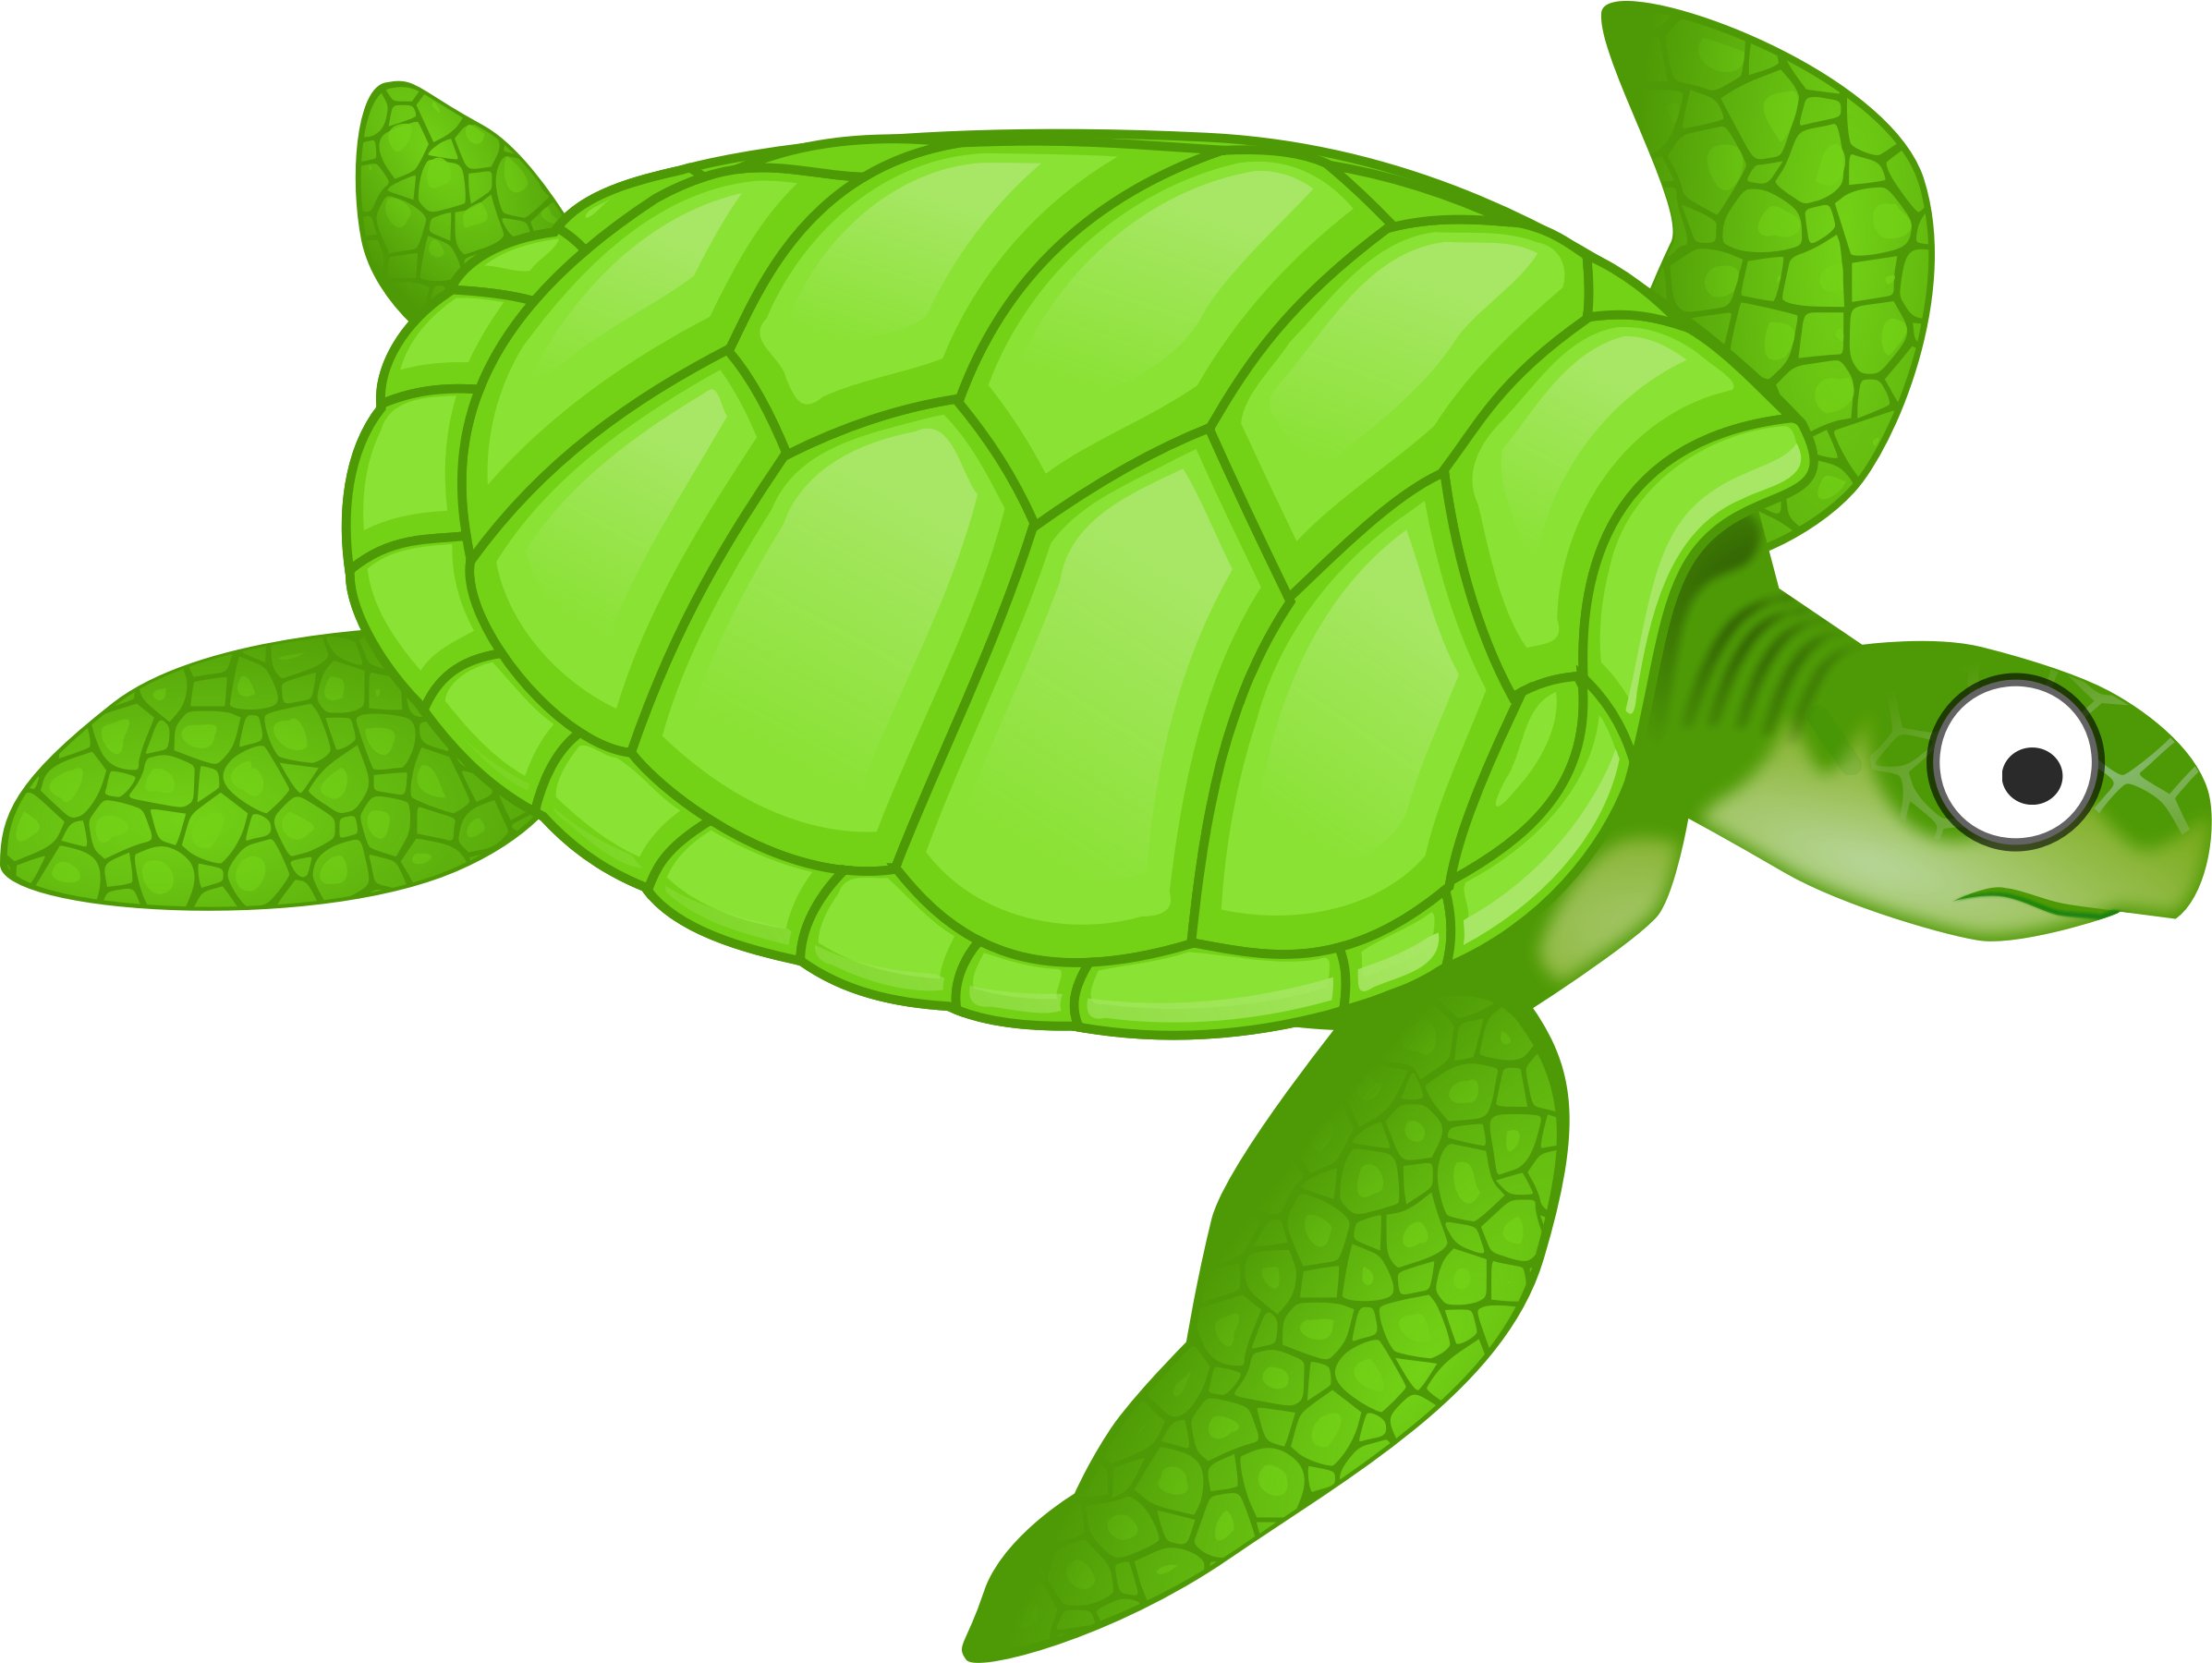

In [4]:
turtle_image

In [5]:
# to create the training set, we will resize the turtle image to 256x256
turtle_image_256x256 = turtle_image.resize((256, 256))

# Background Images

As written above, we will use a generative adversarial network called "BigGAN" pre-trained on ImageNet to create a set of background images

In [6]:
# first, we need to install the python package called `pytorch_pretrained_biggan` (https://github.com/huggingface/pytorch-pretrained-BigGAN)
# if in the notebook environment, please uncomment the following line to install this package
!pip install pytorch_pretrained_biggan
# there might be some errors related to pip's dependency resolver which you can safely ignore

In [7]:
import torch
from pytorch_pretrained_biggan import (
    BigGAN,
    truncated_noise_sample,
    convert_to_images,
    one_hot_from_int,
)

In [8]:
device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(device)
# boilerplate pytorch code enforcing reproducibility
torch.manual_seed(42)
if device.type == "cuda":
    torch.cuda.manual_seed(42)
np.random.seed(42)
random.seed(42)

cuda


BigGAN is a memory-intensive network.

To save time and memory, we will only generate 30 different background images.
Feel free to change this setup as needed.

In [9]:
# load the 256x256 model
model = BigGAN.from_pretrained('biggan-deep-256').to(device).eval()

# every time we will run with batch size of 3 in order to not run out of memory
num_passes = 10
batch_size = 10

# default noise value from the provided repository
truncation = 0.4

background_images = []

for _ in range(num_passes):
    # BigGAN uses imagenet and hence each time we will choose one of 1000 categories
    class_vector = torch.from_numpy(
        one_hot_from_int(np.random.randint(0, 1000, size=batch_size), batch_size=batch_size)
    ).to(device)
    noise_vector = torch.from_numpy(
        truncated_noise_sample(truncation=truncation, batch_size=batch_size)
    ).to(device)

    # Generate the images and convert them to PIL image
    with torch.no_grad():
        output = model(noise_vector, class_vector, truncation).cpu()
        background_images.extend(convert_to_images(output))

# We won't need the GAN model anymore,
# so we can safely delete it and free up some memory
del model
torch.cuda.empty_cache()

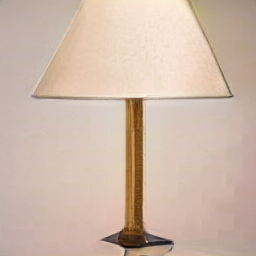

In [10]:
# Let's see how one of the images look like
random.choice(background_images)

# Training Set
Given 30 background images and the turtle image, we will paste the turtle onto the background images.

In [11]:
import torchvision
import torchvision.transforms as transforms

In [12]:
tensor_transform = transforms.ToTensor()

def random_paste(background_image, turtle_image, min_scale=0.25, max_scale=0.65):
    """Randomly scales and pastes the turtle image onto the background image"""

    w, h = turtle_image.size
    # first, we will randomly downscale the turtle image
    new_w = int(random.uniform(min_scale, max_scale) * w)
    new_h = int(random.uniform(min_scale, max_scale) * h)
    resized_turtle_image = turtle_image.resize((new_w, new_h))

    # second, will randomly choose the locations where to paste the new image
    start_w = random.randint(0, w - new_w)
    start_h = random.randint(0, h - new_h)

    # third, will create the blank canvas of the same size as the original image
    canvas_image = Image.new('RGBA', (w, h))

    # and paste the resized turtle onto it, preserving the mask
    canvas_image.paste(resized_turtle_image, (start_w, start_h), resized_turtle_image)

    # Turtle image is of mode RGBA, while background image is of mode RGB;
    # `.paste` requires both of them to be of the same type.
    background_image = background_image.copy().convert('RGBA')
    # finally, will paste the resized turtle onto the background image
    background_image.paste(resized_turtle_image, (start_w, start_h), resized_turtle_image)
    return background_image, canvas_image

In [13]:
training_set = []  # image, segmentation mask

for background_image in background_images:
  # paste the turtle onto background image
  aug_image, aug_mask = random_paste(background_image.copy(), turtle_image_256x256.copy())
  # convert PIL images to pytorch tensors
  training_pair = [
      tensor_transform(aug_image)[:3],  # keep the rgb only
      # For the mask, we only need the last (4th) channel,
      # and we will encode the mask as boolean
      tensor_transform(aug_mask)[-1:] > 0,
  ]
  training_set.append(training_pair)
print("These are the number of training images: ", len(training_set))

These are the number of training images:  100


In [14]:
# stop after generating train images

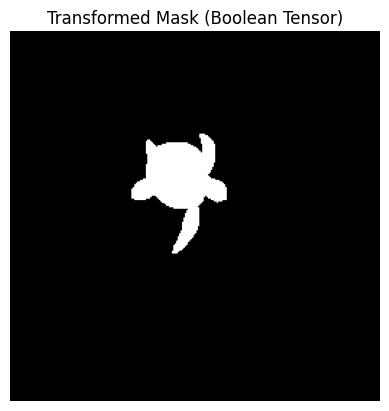

In [15]:
#visualizing just the mask : MYCODE
import matplotlib.pyplot as plt

# Convert the tensor mask back to numpy to visualize
import numpy as np

tensor_mask = tensor_transform(aug_mask)[-1:] > 0  # Boolean mask tensor
mask_numpy = tensor_mask.squeeze().numpy()  # Convert to numpy and remove the extra dimension

# Visualize the binary mask
plt.imshow(mask_numpy, cmap='gray')
plt.title("Transformed Mask (Boolean Tensor)")
plt.axis('off')
plt.show()

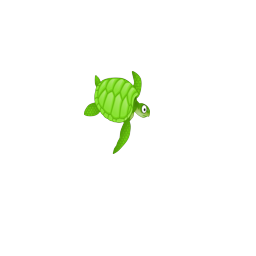

In [16]:
# mask_numpy
aug_mask

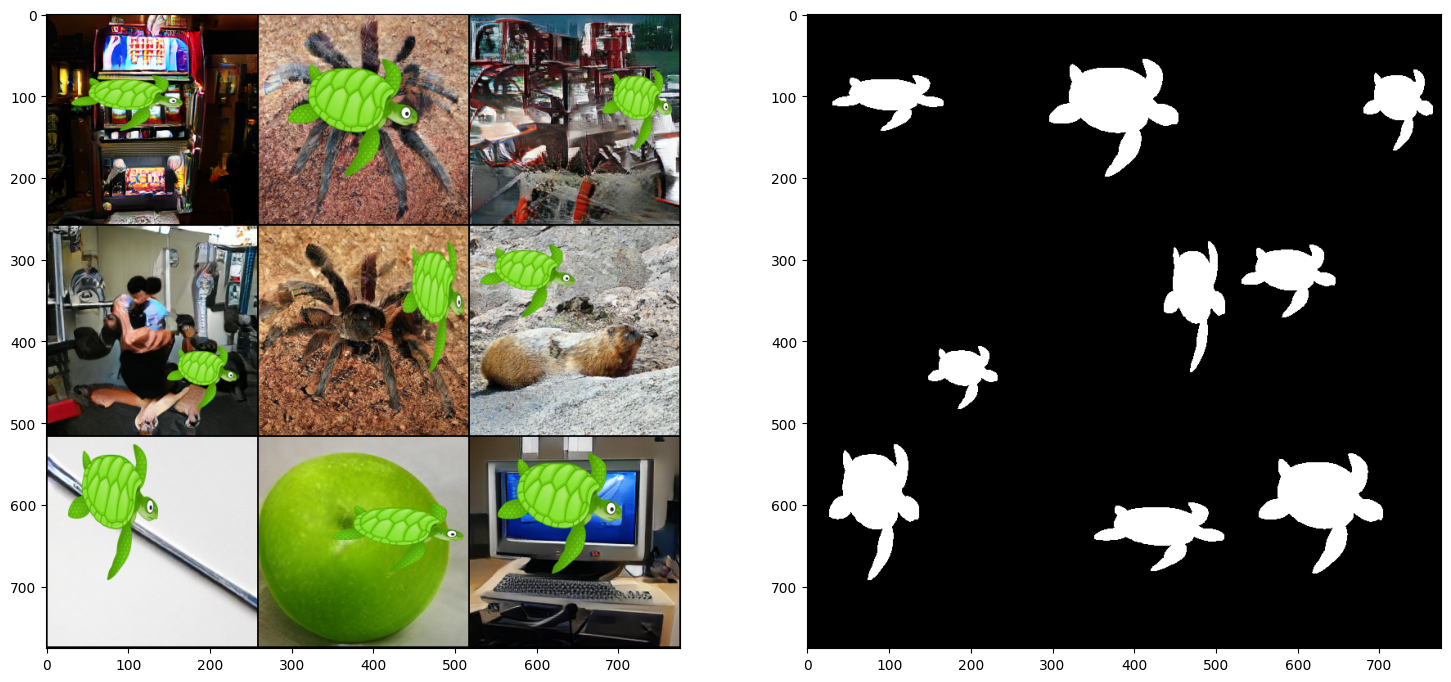

In [17]:
# Let's visualise some subset of the training set
sample_indices = np.random.choice(len(training_set), size=9, replace=False)
sample_images = []
sample_masks = []
for i in sample_indices:
    image, mask = training_set[i]
    sample_images.append(image)
    sample_masks.append(mask)

plt.figure(figsize=(18, 18))
plt.subplot(121)
plt.imshow(torchvision.utils.make_grid(sample_images, nrow=3).permute(1, 2, 0).cpu().numpy())
plt.subplot(122)
plt.imshow(torchvision.utils.make_grid(sample_masks, nrow=3).permute(1, 2, 0).float().cpu().numpy())

# Test Image
Now, let's load the test image. As mentioned above, it is of a slightly higher 512x512 resolution.

Downloading...
From: https://drive.google.com/uc?id=1_55KX8AK8pZ936Zv27t8Q-ZY8BJjuBqa
To: /home/shilpifire/Documents/Turtle_Segmentation/test.png
100%|██████████| 413k/413k [00:00<00:00, 6.31MB/s]

RGB (512, 512)


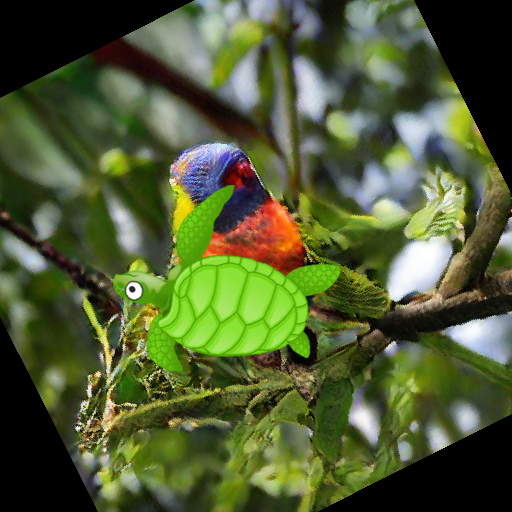

In [18]:
gdown.download("https://drive.google.com/uc?id=1_55KX8AK8pZ936Zv27t8Q-ZY8BJjuBqa", "test.png", quiet=False)
test_image = Image.open('./test.png')
# it is a 3-channel RGB image of size 512x512
print(test_image.mode, test_image.size)
test_image

# Task 1: Predicting segmentation mask

*This is where you need to implement your deep learning solution. Your approach should output a result at the native 512x512 resolution of the test image.*

In [19]:
#traning happens here: 
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import MaskRCNN
import torch.nn as nn
import torch.optim as optim
import neptune

# Initialize Neptune
run = neptune.init_run(
    project="shilpiprd/Turtle-Seg",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkY2NjNmM1YS01YzBiLTQ0YjctOTJjMy04NGRmM2JlMzRmNGYifQ==",
)
# Assuming tensor_transform and other needed imports are already defined
# tensor_transform = transforms.ToTensor()
backbone = resnet_fpn_backbone('resnet101', pretrained = True)
model = MaskRCNN(backbone, num_classes=2).to(device)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)


class TurtleDataset(Dataset):
    def __init__(self, training_set):
        self.training_set = training_set

    def __len__(self):
        return len(self.training_set)

    def __getitem__(self, idx):
        # Extract the image and mask from training_set
        image_tensor, mask_tensor = self.training_set[idx]

        # Extract bounding box coordinates from mask
        mask_np = mask_tensor.squeeze().cpu().numpy()
        # print('mask_np: ', mask_np)
        pos = np.where(mask_np)

        if len(pos[0]) == 0 or len(pos[1]) == 0:
            raise ValueError("Empty mask found")

        # Calculate bounding box coordinates
        x_min = np.min(pos[1])
        x_max = np.max(pos[1])
        y_min = np.min(pos[0])
        y_max = np.max(pos[0])
        boxes = [[x_min, y_min, x_max, y_max]]

        # Convert to torch tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)  # Assuming turtle is class 1
        masks_tensor = mask_tensor.to(torch.uint8).squeeze(0).unsqueeze(0)  # Ensure shape is [N, H, W] where N=1

        # Prepare the target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks_tensor
        }

        return image_tensor, target

# Custom Collate Function for DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

# Create Dataset and DataLoader
# print(len(training_set), 'lentraining set')
dataset = TurtleDataset(training_set)
batch_size = 5
data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)

# Training Loop

num_epochs = 300

model.train()
patience = 20
best_loss = float('inf')
count = 0
for epoch in range(num_epochs):
    loss_epoch = 0
    pbar = tqdm(data_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

    for images, targets in pbar:
        # Move images and targets to the appropriate device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(images, targets)

        # Calculate the loss
        losses = sum(loss for loss in output.values())

        losses.backward()
        # <-
        # Check and log gradient norms
        grad_norms = []
        nan_detected = False
        for name, param in model.named_parameters():
            if param.grad is not None:
                grad_norm = param.grad.norm().item()
                grad_norms.append(grad_norm)
                # Check if any gradient is NaN
                if torch.isnan(param.grad).any():
                    print(f"NaN detected in gradient for parameter: {name}")
                    nan_detected = True
        # >
        optimizer.step()

        running_loss = losses.item()
        # pbar.set_postfix({'Loss': running_loss})
        loss_epoch += running_loss

    # Calculate average loss for the epoch
    avg_loss = loss_epoch / len(data_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")
    run["training/loss"].log(avg_loss)
    # Early stopping logic
    if avg_loss < best_loss:
        best_loss = avg_loss
        count = 0
    else:
        count += 1
        if count >= patience:
            print(f"Stopping early at epoch {epoch + 1}. No improvement in loss for {patience} consecutive epochs.")
            break
run.stop()

# Save the model weights
torch.save(model.state_dict(), 'saved_model.pth')
torch.save(model, 'full_model.pth')  # Saving full model

[neptune] [warning] NeptuneWarning: By default, these monitoring options are disabled in interactive sessions: 'capture_stdout', 'capture_stderr', 'capture_traceback', 'capture_hardware_metrics'. You can set them to 'True' when initializing the run and the monitoring will continue until you call run.stop() or the kernel stops. NOTE: To track the source files, pass their paths to the 'source_code' argument. For help, see: https://docs.neptune.ai/logging/source_code/


[neptune] [info   ] Neptune initialized. Open in the app: https://app.neptune.ai/shilpiprd/Turtle-Seg/e/TUR-1


/home/shilpifire/colab/lib/python3.12/site-packages/torchvision/models/_utils.py:135: UserWarning: Using 'backbone_name' as positional parameter(s) is deprecated since 0.13 and may be removed in the future. Please use keyword parameter(s) instead.
  warnings.warn(
/home/shilpifire/colab/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/shilpifire/colab/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet101_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet101_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet101-63fe2227.pth" to /home/shi

Epoch [1/300], Loss: 1.7265


Epoch 2/300: 100%|██████████| 20/20 [00:13<00:00,  1.47it/s]


Epoch [2/300], Loss: 0.7933


Epoch 3/300: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch [3/300], Loss: 0.4712


Epoch 4/300: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch [4/300], Loss: 0.3547


Epoch 5/300: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch [5/300], Loss: 0.3045


Epoch 6/300: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch [6/300], Loss: 0.2744


Epoch 7/300: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch [7/300], Loss: 0.2549


Epoch 8/300: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch [8/300], Loss: 0.2315


Epoch 9/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [9/300], Loss: 0.2164


Epoch 10/300: 100%|██████████| 20/20 [00:13<00:00,  1.46it/s]


Epoch [10/300], Loss: 0.1947


Epoch 11/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [11/300], Loss: 0.1859


Epoch 12/300: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch [12/300], Loss: 0.1728


Epoch 13/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [13/300], Loss: 0.1614


Epoch 14/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [14/300], Loss: 0.1529


Epoch 15/300: 100%|██████████| 20/20 [00:13<00:00,  1.45it/s]


Epoch [15/300], Loss: 0.1466


Epoch 16/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [16/300], Loss: 0.1457


Epoch 17/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [17/300], Loss: 0.1390


Epoch 18/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [18/300], Loss: 0.1359


Epoch 19/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [19/300], Loss: 0.1351


Epoch 20/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [20/300], Loss: 0.1312


Epoch 21/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [21/300], Loss: 0.1281


Epoch 22/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [22/300], Loss: 0.1261


Epoch 23/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [23/300], Loss: 0.1245


Epoch 24/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [24/300], Loss: 0.1233


Epoch 25/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [25/300], Loss: 0.1235


Epoch 26/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [26/300], Loss: 0.1213


Epoch 27/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [27/300], Loss: 0.1204


Epoch 28/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [28/300], Loss: 0.1159


Epoch 29/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [29/300], Loss: 0.1152


Epoch 30/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [30/300], Loss: 0.1156


Epoch 31/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [31/300], Loss: 0.1112


Epoch 32/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [32/300], Loss: 0.1107


Epoch 33/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [33/300], Loss: 0.1085


Epoch 34/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [34/300], Loss: 0.1055


Epoch 35/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [35/300], Loss: 0.1064


Epoch 36/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [36/300], Loss: 0.1060


Epoch 37/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [37/300], Loss: 0.1067


Epoch 38/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [38/300], Loss: 0.1062


Epoch 39/300: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


Epoch [39/300], Loss: 0.1032


Epoch 40/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [40/300], Loss: 0.1027


Epoch 41/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [41/300], Loss: 0.1010


Epoch 42/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [42/300], Loss: 0.1007


Epoch 43/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [43/300], Loss: 0.1005


Epoch 44/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [44/300], Loss: 0.0991


Epoch 45/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [45/300], Loss: 0.1014


Epoch 46/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [46/300], Loss: 0.1012


Epoch 47/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [47/300], Loss: 0.1007


Epoch 48/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [48/300], Loss: 0.0975


Epoch 49/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [49/300], Loss: 0.0981


Epoch 50/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [50/300], Loss: 0.0972


Epoch 51/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [51/300], Loss: 0.0951


Epoch 52/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [52/300], Loss: 0.0947


Epoch 53/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [53/300], Loss: 0.0944


Epoch 54/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [54/300], Loss: 0.0964


Epoch 55/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [55/300], Loss: 0.0952


Epoch 56/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [56/300], Loss: 0.0951


Epoch 57/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [57/300], Loss: 0.0941


Epoch 58/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [58/300], Loss: 0.0935


Epoch 59/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [59/300], Loss: 0.0939


Epoch 60/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [60/300], Loss: 0.0921


Epoch 61/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [61/300], Loss: 0.0909


Epoch 62/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [62/300], Loss: 0.0931


Epoch 63/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [63/300], Loss: 0.0919


Epoch 64/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [64/300], Loss: 0.0905


Epoch 65/300: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


Epoch [65/300], Loss: 0.0910


Epoch 66/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [66/300], Loss: 0.0922


Epoch 67/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [67/300], Loss: 0.0914


Epoch 68/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [68/300], Loss: 0.0898


Epoch 69/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [69/300], Loss: 0.0886


Epoch 70/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [70/300], Loss: 0.0888


Epoch 71/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [71/300], Loss: 0.0886


Epoch 72/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [72/300], Loss: 0.0899


Epoch 73/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [73/300], Loss: 0.0894


Epoch 74/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [74/300], Loss: 0.0873


Epoch 75/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [75/300], Loss: 0.0880


Epoch 76/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [76/300], Loss: 0.0899


Epoch 77/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [77/300], Loss: 0.0880


Epoch 78/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [78/300], Loss: 0.0876


Epoch 79/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [79/300], Loss: 0.0870


Epoch 80/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [80/300], Loss: 0.0851


Epoch 81/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [81/300], Loss: 0.0854


Epoch 82/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [82/300], Loss: 0.0852


Epoch 83/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [83/300], Loss: 0.0852


Epoch 84/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [84/300], Loss: 0.0856


Epoch 85/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [85/300], Loss: 0.0851


Epoch 86/300: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Epoch [86/300], Loss: 0.0850


Epoch 87/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [87/300], Loss: 0.0844


Epoch 88/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [88/300], Loss: 0.0842


Epoch 89/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [89/300], Loss: 0.0838


Epoch 90/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [90/300], Loss: 0.0860


Epoch 91/300: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


Epoch [91/300], Loss: 0.0853


Epoch 92/300: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


Epoch [92/300], Loss: 0.0831


Epoch 93/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [93/300], Loss: 0.0831


Epoch 94/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [94/300], Loss: 0.0844


Epoch 95/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [95/300], Loss: 0.0831


Epoch 96/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [96/300], Loss: 0.0822


Epoch 97/300: 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Epoch [97/300], Loss: 0.0835


Epoch 98/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [98/300], Loss: 0.0834


Epoch 99/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [99/300], Loss: 0.0834


Epoch 100/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [100/300], Loss: 0.0827


Epoch 101/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [101/300], Loss: 0.0837


Epoch 102/300: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Epoch [102/300], Loss: 0.0820


Epoch 103/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [103/300], Loss: 0.0823


Epoch 104/300: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


Epoch [104/300], Loss: 0.0836


Epoch 105/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [105/300], Loss: 0.0834


Epoch 106/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [106/300], Loss: 0.0829


Epoch 107/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [107/300], Loss: 0.0813


Epoch 108/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [108/300], Loss: 0.0816


Epoch 109/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [109/300], Loss: 0.0809


Epoch 110/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [110/300], Loss: 0.0814


Epoch 111/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [111/300], Loss: 0.0809


Epoch 112/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [112/300], Loss: 0.0806


Epoch 113/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [113/300], Loss: 0.0805


Epoch 114/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [114/300], Loss: 0.0801


Epoch 115/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [115/300], Loss: 0.0805


Epoch 116/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [116/300], Loss: 0.0794


Epoch 117/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [117/300], Loss: 0.0801


Epoch 118/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [118/300], Loss: 0.0806


Epoch 119/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [119/300], Loss: 0.0803


Epoch 120/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [120/300], Loss: 0.0798


Epoch 121/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [121/300], Loss: 0.0799


Epoch 122/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [122/300], Loss: 0.0811


Epoch 123/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [123/300], Loss: 0.0807


Epoch 124/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [124/300], Loss: 0.0804


Epoch 125/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [125/300], Loss: 0.0791


Epoch 126/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [126/300], Loss: 0.0798


Epoch 127/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [127/300], Loss: 0.0795


Epoch 128/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [128/300], Loss: 0.0790


Epoch 129/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [129/300], Loss: 0.0796


Epoch 130/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [130/300], Loss: 0.0788


Epoch 131/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [131/300], Loss: 0.0792


Epoch 132/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [132/300], Loss: 0.0789


Epoch 133/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [133/300], Loss: 0.0790


Epoch 134/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [134/300], Loss: 0.0784


Epoch 135/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [135/300], Loss: 0.0782


Epoch 136/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [136/300], Loss: 0.0779


Epoch 137/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [137/300], Loss: 0.0780


Epoch 138/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [138/300], Loss: 0.0792


Epoch 139/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [139/300], Loss: 0.0794


Epoch 140/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [140/300], Loss: 0.0784


Epoch 141/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [141/300], Loss: 0.0781


Epoch 142/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [142/300], Loss: 0.0777


Epoch 143/300: 100%|██████████| 20/20 [00:13<00:00,  1.43it/s]


Epoch [143/300], Loss: 0.0790


Epoch 144/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [144/300], Loss: 0.0832


Epoch 145/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [145/300], Loss: 0.0806


Epoch 146/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [146/300], Loss: 0.0808


Epoch 147/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [147/300], Loss: 0.0794


Epoch 148/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [148/300], Loss: 0.0780


Epoch 149/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [149/300], Loss: 0.0779


Epoch 150/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [150/300], Loss: 0.0777


Epoch 151/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [151/300], Loss: 0.0782


Epoch 152/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [152/300], Loss: 0.0773


Epoch 153/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [153/300], Loss: 0.0768


Epoch 154/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [154/300], Loss: 0.0773


Epoch 155/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [155/300], Loss: 0.0774


Epoch 156/300: 100%|██████████| 20/20 [00:13<00:00,  1.44it/s]


Epoch [156/300], Loss: 0.0779


Epoch 157/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [157/300], Loss: 0.0761


Epoch 158/300: 100%|██████████| 20/20 [00:14<00:00,  1.43it/s]


Epoch [158/300], Loss: 0.0769


Epoch 159/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [159/300], Loss: 0.0773


Epoch 160/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [160/300], Loss: 0.0767


Epoch 161/300: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Epoch [161/300], Loss: 0.0765


Epoch 162/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [162/300], Loss: 0.0768


Epoch 163/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [163/300], Loss: 0.0771


Epoch 164/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [164/300], Loss: 0.0766


Epoch 165/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [165/300], Loss: 0.0766


Epoch 166/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [166/300], Loss: 0.0768


Epoch 167/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [167/300], Loss: 0.0765


Epoch 168/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [168/300], Loss: 0.0768


Epoch 169/300: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


Epoch [169/300], Loss: 0.0769


Epoch 170/300: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Epoch [170/300], Loss: 0.0763


Epoch 171/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [171/300], Loss: 0.0770


Epoch 172/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [172/300], Loss: 0.0775


Epoch 173/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [173/300], Loss: 0.0760


Epoch 174/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [174/300], Loss: 0.0756


Epoch 175/300: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Epoch [175/300], Loss: 0.0758


Epoch 176/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [176/300], Loss: 0.0760


Epoch 177/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [177/300], Loss: 0.0766


Epoch 178/300: 100%|██████████| 20/20 [00:14<00:00,  1.42it/s]


Epoch [178/300], Loss: 0.0765


Epoch 179/300: 100%|██████████| 20/20 [00:14<00:00,  1.41it/s]


Epoch [179/300], Loss: 0.0763


Epoch 180/300: 100%|██████████| 20/20 [00:14<00:00,  1.39it/s]


Epoch [180/300], Loss: 0.0764


Epoch 181/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [181/300], Loss: 0.0751


Epoch 182/300: 100%|██████████| 20/20 [00:23<00:00,  1.19s/it]


Epoch [182/300], Loss: 0.0757


Epoch 183/300: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Epoch [183/300], Loss: 0.0756


Epoch 184/300: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch [184/300], Loss: 0.0755


Epoch 185/300: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Epoch [185/300], Loss: 0.0758


Epoch 186/300: 100%|██████████| 20/20 [00:16<00:00,  1.23it/s]


Epoch [186/300], Loss: 0.0756


Epoch 187/300: 100%|██████████| 20/20 [00:15<00:00,  1.31it/s]


Epoch [187/300], Loss: 0.0751


Epoch 188/300: 100%|██████████| 20/20 [00:15<00:00,  1.28it/s]


Epoch [188/300], Loss: 0.0747


Epoch 189/300: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch [189/300], Loss: 0.0753


Epoch 190/300: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Epoch [190/300], Loss: 0.0754


Epoch 191/300: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Epoch [191/300], Loss: 0.0755


Epoch 192/300: 100%|██████████| 20/20 [00:15<00:00,  1.26it/s]


Epoch [192/300], Loss: 0.0758


Epoch 193/300: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch [193/300], Loss: 0.0758


Epoch 194/300: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Epoch [194/300], Loss: 0.0762


Epoch 195/300: 100%|██████████| 20/20 [00:23<00:00,  1.17s/it]


Epoch [195/300], Loss: 0.0757


Epoch 196/300: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Epoch [196/300], Loss: 0.0746


Epoch 197/300: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Epoch [197/300], Loss: 0.0758


Epoch 198/300: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Epoch [198/300], Loss: 0.0754


Epoch 199/300: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch [199/300], Loss: 0.0742


Epoch 200/300: 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Epoch [200/300], Loss: 0.0744


Epoch 201/300: 100%|██████████| 20/20 [00:20<00:00,  1.02s/it]


Epoch [201/300], Loss: 0.0750


Epoch 202/300: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch [202/300], Loss: 0.0746


Epoch 203/300: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


Epoch [203/300], Loss: 0.0751


Epoch 204/300: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Epoch [204/300], Loss: 0.0742


Epoch 205/300: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


Epoch [205/300], Loss: 0.0745


Epoch 206/300: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Epoch [206/300], Loss: 0.0743


Epoch 207/300: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Epoch [207/300], Loss: 0.0741


Epoch 208/300: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Epoch [208/300], Loss: 0.0738


Epoch 209/300: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Epoch [209/300], Loss: 0.0738


Epoch 210/300: 100%|██████████| 20/20 [00:15<00:00,  1.32it/s]


Epoch [210/300], Loss: 0.0737


Epoch 211/300: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch [211/300], Loss: 0.0746


Epoch 212/300: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Epoch [212/300], Loss: 0.0740


Epoch 213/300: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Epoch [213/300], Loss: 0.0732


Epoch 214/300: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch [214/300], Loss: 0.0735


Epoch 215/300: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Epoch [215/300], Loss: 0.0743


Epoch 216/300: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Epoch [216/300], Loss: 0.0739


Epoch 217/300: 100%|██████████| 20/20 [00:15<00:00,  1.27it/s]


Epoch [217/300], Loss: 0.0747


Epoch 218/300: 100%|██████████| 20/20 [00:15<00:00,  1.30it/s]


Epoch [218/300], Loss: 0.0743


Epoch 219/300: 100%|██████████| 20/20 [00:16<00:00,  1.24it/s]


Epoch [219/300], Loss: 0.0740


Epoch 220/300: 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Epoch [220/300], Loss: 0.0736


Epoch 221/300: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Epoch [221/300], Loss: 0.0740


Epoch 222/300: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Epoch [222/300], Loss: 0.0736


Epoch 223/300: 100%|██████████| 20/20 [00:14<00:00,  1.34it/s]


Epoch [223/300], Loss: 0.0733


Epoch 224/300: 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Epoch [224/300], Loss: 0.0742


Epoch 225/300: 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Epoch [225/300], Loss: 0.0742


Epoch 226/300: 100%|██████████| 20/20 [00:14<00:00,  1.35it/s]


Epoch [226/300], Loss: 0.0740


Epoch 227/300: 100%|██████████| 20/20 [00:14<00:00,  1.38it/s]


Epoch [227/300], Loss: 0.0734


Epoch 228/300: 100%|██████████| 20/20 [00:15<00:00,  1.29it/s]


Epoch [228/300], Loss: 0.0733


Epoch 229/300: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]


Epoch [229/300], Loss: 0.0732


Epoch 230/300: 100%|██████████| 20/20 [00:14<00:00,  1.36it/s]


Epoch [230/300], Loss: 0.0733


Epoch 231/300: 100%|██████████| 20/20 [00:15<00:00,  1.33it/s]


Epoch [231/300], Loss: 0.0743


Epoch 232/300: 100%|██████████| 20/20 [00:14<00:00,  1.40it/s]


Epoch [232/300], Loss: 0.0750


Epoch 233/300: 100%|██████████| 20/20 [00:14<00:00,  1.37it/s]

Epoch [233/300], Loss: 0.0744
Stopping early at epoch 233. No improvement in loss for 20 consecutive epochs.
[neptune] [info   ] Shutting down background jobs, please wait a moment...


[neptune] [info   ] Done!
[neptune] [info   ] All 0 operations synced, thanks for waiting!
[neptune] [info   ] Explore the metadata in the Neptune app: https://app.neptune.ai/shilpiprd/Turtle-Seg/e/TUR-1/metadata


In [20]:
sdf

NameError: name 'sdf' is not defined

In [ ]:
#new training with validation : 
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import MaskRCNN
import torch.nn as nn
import torch.optim as optim
import neptune

# Initialize Neptune
run = neptune.init_run(
    project="shilpiprd/Turtle-Seg",
    api_token="eyJhcGlfYWRkcmVzcyI6Imh0dHBzOi8vYXBwLm5lcHR1bmUuYWkiLCJhcGlfdXJsIjoiaHR0cHM6Ly9hcHAubmVwdHVuZS5haSIsImFwaV9rZXkiOiJkY2NjNmM1YS01YzBiLTQ0YjctOTJjMy04NGRmM2JlMzRmNGYifQ==",
)
# Assuming tensor_transform and other needed imports are already defined
# tensor_transform = transforms.ToTensor()
backbone = resnet_fpn_backbone('resnet101', pretrained = True)
model = MaskRCNN(backbone, num_classes=2).to(device)
model = model.to(device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.001, momentum = 0.9)


class TurtleDataset(Dataset):
    def __init__(self, training_set):
        self.training_set = training_set

    def __len__(self):
        return len(self.training_set)

    def __getitem__(self, idx):
        # Extract the image and mask from training_set
        image_tensor, mask_tensor = self.training_set[idx]

        # Extract bounding box coordinates from mask
        mask_np = mask_tensor.squeeze().cpu().numpy()
        # print('mask_np: ', mask_np)
        pos = np.where(mask_np)

        if len(pos[0]) == 0 or len(pos[1]) == 0:
            raise ValueError("Empty mask found")

        # Calculate bounding box coordinates
        x_min = np.min(pos[1])
        x_max = np.max(pos[1])
        y_min = np.min(pos[0])
        y_max = np.max(pos[0])
        boxes = [[x_min, y_min, x_max, y_max]]

        # Convert to torch tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.ones((len(boxes),), dtype=torch.int64)  # Assuming turtle is class 1
        masks_tensor = mask_tensor.to(torch.uint8).squeeze(0).unsqueeze(0)  # Ensure shape is [N, H, W] where N=1

        # Prepare the target dictionary
        target = {
            "boxes": boxes,
            "labels": labels,
            "masks": masks_tensor
        }

        return image_tensor, target

# Custom Collate Function for DataLoader
def collate_fn(batch):
    return tuple(zip(*batch))

def validate(model, val_loader, epoch, num_epochs):
    model.eval() 
    pbar = tqdm(val_loader) 
    val_loss = 0 
    with torch.no_grad(): 
        for images, targets in pbar: 
            images = list(image.to(device) for image in images)
            targets = [{k: v.to(device) for k, v in t.items()} for t in targets] 

            output = model(images, targets) 
            val_loss = sum(loss for loss in output.values()) 

            val_loss += val_loss.item()

    avg_loss = val_loss / len(val_loader) 
    print(f"Epoch: {(epoch+1) / num_epochs}, Validation Loss: {avg_loss}")
    run['Validation/loss'].log(avg_loss)

    return avg_loss

# Create Dataset and DataLoader
# print(len(training_set), 'lentraining set')

val_split = int(len(training_set) * 0.1)
train_set = training_set[val_split:]  # First 90% for training
val_set = training_set[:val_split]  


# dataset = TurtleDataset(training_set) 
train_dataset = TurtleDataset(train_set) 
val_dataset = TurtleDataset(val_set) 

batch_size = 5
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=False, num_workers=4, collate_fn=lambda x: tuple(zip(*x)))
# data_loader = DataLoader(dataset, batch_size=batch_size, shuffle=True, num_workers=4, collate_fn=collate_fn)

# Training Loop

num_epochs = 300

patience = 20
best_loss = float('inf')
count = 0
for epoch in range(num_epochs):
    model.train()
    loss_epoch = 0
    pbar = tqdm(data_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")

    for images, targets in pbar:
        # Move images and targets to the appropriate device
        images = list(image.to(device) for image in images)
        targets = [{k: v.to(device) for k, v in t.items()} for t in targets]

        # Zero the parameter gradients
        optimizer.zero_grad()

        # Forward pass
        output = model(images, targets)

        # Calculate the loss
        losses = sum(loss for loss in output.values())

        losses.backward()
        # <-
        # Check and log gradient norms
        grad_norms = []
        nan_detected = False
        for name, param in model.named_parameters():
            if param.grad is not None:
                grad_norm = param.grad.norm().item()
                grad_norms.append(grad_norm)
                # Check if any gradient is NaN
                if torch.isnan(param.grad).any():
                    print(f"NaN detected in gradient for parameter: {name}")
                    nan_detected = True
        # >
        optimizer.step()

        running_loss = losses.item()
        # pbar.set_postfix({'Loss': running_loss})
        loss_epoch += running_loss

    # Calculate average loss for the epoch
    avg_loss = loss_epoch / len(data_loader)
    print(f"Epoch [{epoch + 1}/{num_epochs}], Loss: {avg_loss:.4f}")
    run["training/loss"].log(avg_loss)

    avg_val_loss = validate(model, val_loader, epoch, num_epochs)
    # Early stopping logic
    if avg_val_loss < best_loss:
        best_loss = avg_val_loss
        count = 0
    else:
        count += 1
        if count >= patience:
            print(f"Stopping early at epoch {epoch + 1}. No improvement in loss for {patience} consecutive epochs.")
            break
run.stop()

# Save the model weights
torch.save(model.state_dict(), 'saved_model.pth')
torch.save(model, 'full_model.pth')  # Saving full model

In [21]:
#checking input
pbar = tqdm(data_loader, desc=f"Epoch {epoch + 1}/{num_epochs}")
print(len(pbar))
for idx, (images, targets) in enumerate(pbar):
  print('One Loop')
  for i, (image, target) in enumerate(zip(images, targets)):
      print(f"Image {i} min: {image.min()}, max: {image.max()}")
      print(f"Boxes: {target['boxes']}")
      print(f"Masks shape: {target['masks'].shape}, dtype: {target['masks'].dtype}")
      print("mask: ", target['masks'])

Epoch 233/300:   0%|          | 0/20 [00:00<?, ?it/s]

20


Epoch 233/300:   5%|▌         | 1/20 [00:00<00:03,  6.11it/s]

One Loop
Image 0 min: 0.0, max: 1.0
Boxes: tensor([[ 35., 108., 117., 225.]])
Masks shape: torch.Size([1, 256, 256]), dtype: torch.uint8
mask:  tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
Image 1 min: 0.0, max: 1.0
Boxes: tensor([[ 62.,  28., 136., 166.]])
Masks shape: torch.Size([1, 256, 256]), dtype: torch.uint8
mask:  tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
Image 2 min: 0.0, max: 1.0
Boxes: tensor([[119.,  26., 250., 145.]])
Masks shape: torch.Size([1, 256, 256]), dtype: torch.uint8
mask:  tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0

Epoch 233/300: 100%|██████████| 20/20 [00:00<00:00, 57.69it/s]

tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
Image 3 min: 0.0, max: 1.0
Boxes: tensor([[171., 124., 241., 211.]])
Masks shape: torch.Size([1, 256, 256]), dtype: torch.uint8
mask:  tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.uint8)
Image 4 min: 0.0, max: 1.0
Boxes: tensor([[104., 117., 254., 202.]])
Masks shape: torch.Size([1, 256, 256]), dtype: torch.uint8
mask:  tensor([[[0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         ...,
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0],
         [0, 0, 0,  ..., 0, 0, 0]]], dtype=torch.ui

this ran
torch.Size([3, 512, 512]) torch.Size([512, 512])


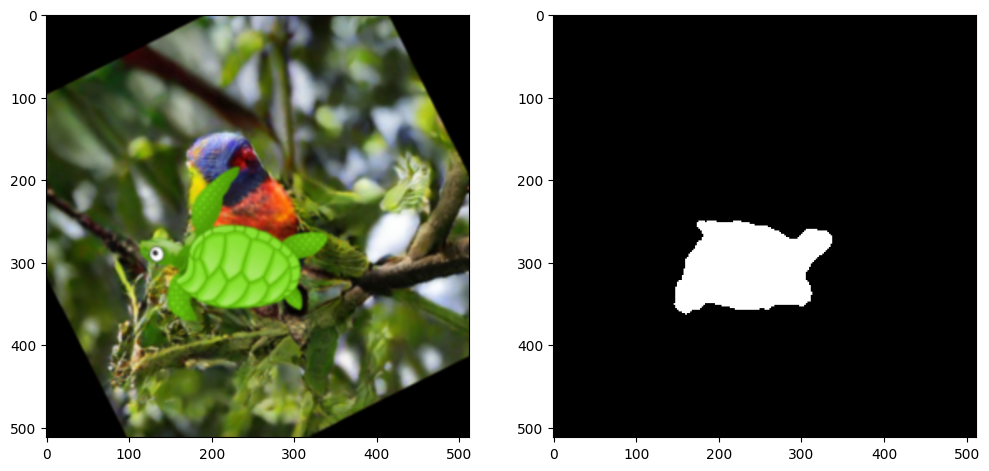

In [22]:
import torch
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms
from tqdm import tqdm
from torchvision.models.detection.backbone_utils import resnet_fpn_backbone
from torchvision.models.detection import MaskRCNN
import torch.nn as nn
import torch.optim as optim
# TODO: Implement and train the deep model
# TODO: Save the model weights and upload them to Google Drive
load_model_weights = False
if load_model_weights:
    saved_model_url = "https://drive.google.com/uc?id=1C5fQVYSe8HLws5kw4B1gcksCvnk2Wc7E"
    gdown.download(saved_model_url, "saved_model.pth", quiet=True)

    backbone = resnet_fpn_backbone('resnet101', pretrained = True)
    model = MaskRCNN(backbone, num_classes=2).to(device)
    model.load_state_dict(torch.load("save_model.pth", map_location = device))
    model.eval()

    # TODO: Load your saved model weights e.g. torch.load("saved_model.pth")
else:
    try:
      print('this ran')
      model.eval()
    except:
      pass

tensor_transform = transforms.Compose([
    transforms.Resize((256, 256)),
    transforms.ToTensor()
])

test_image_tensor = tensor_transform(test_image).unsqueeze(0).to(device)
# print("Finally, test_image_tesnsor.shape : ", test_image_tensor.shape)
def get_mask_from_image(test_image):

  # TODO: Use the deep model that predicts the segmentation mask on the test image
  # The model with the saved weights should be used, if load_model_weights is True
  with torch.no_grad():  # Disable gradient calculation to save memory and speed up computation
        output = model(test_image_tensor)[0]
        test_mask = output['masks'][0, 0].cpu() > 0.5

  extra_test_mask = test_image.mean(0) < 0.5
  # print("ex: ", extra_test_mask) #This is a list of True/False
  return test_mask.byte()

test_mask_tensor = get_mask_from_image(test_image_tensor)

resize_transform = transforms.Resize((512, 512))
resized_image = resize_transform(test_image_tensor.squeeze(0).cpu())  # Remove batch dimension
resized_mask = resize_transform(test_mask_tensor.unsqueeze(0)).squeeze(0)  # Add and remove channel dimension

test_image_tensor = resized_image
test_mask_tensor = resized_mask

print(test_image_tensor.shape, test_mask_tensor.shape)
plt.figure(figsize=(12, 12))
plt.subplot(121)
# print("type: ", test_image_tensor.cpu().numpy().shape)
plt.imshow(test_image_tensor.cpu().squeeze().numpy().transpose(1, 2, 0))
plt.subplot(122)
plt.imshow(test_mask_tensor.numpy(), cmap="gray", vmin=0, vmax=1)

In [ ]:
# test_image_tensor
# test_mask_tensor
print(test_image_tensor.shape, test_mask_tensor.shape)

torch.Size([1, 3, 256, 256]) torch.Size([256, 256])


In [ ]:
# torch.where(test_mask_tensor == 1)
# torch.where(test_mask_tensor == 1)
# print(max(a))
y_coords, x_coords = torch.where(test_mask_tensor == 1)
mask_points = torch.stack([x_coords, y_coords], dim=1)
mask_points

tensor([[ 96, 127],
        [ 97, 127],
        [ 98, 127],
        ...,
        [121, 178],
        [122, 178],
        [123, 178]])

In [ ]:
hull = set()

def findSide(p1, p2, p):
    val = (p[1] - p1[1]) * (p2[0] - p1[0]) - (p2[1] - p1[1]) * (p[0] - p1[0])

    if val > 0:
        return 1
    if val < 0:
        return -1
    return 0

# returns a value proportional to the distance
# between the point p and the line joining the
# points p1 and p2
def lineDist(p1, p2, p):
    return abs((p[1] - p1[1]) * (p2[0] - p1[0]) -
            (p2[1] - p1[1]) * (p[0] - p1[0]))

# End points of line L are p1 and p2. side can have value
# 1 or -1 specifying each of the parts made by the line L
def quickHull(a, n, p1, p2, side):

    ind = -1
    max_dist = 0

    # finding the point with maximum distance
    # from L and also on the specified side of L.
    for i in range(n):
        temp = lineDist(p1, p2, a[i])

        if (findSide(p1, p2, a[i]) == side) and (temp > max_dist):
            ind = i
            max_dist = temp

    # If no point is found, add the end points
    # of L to the convex hull.
    if ind == -1:
        hull.add("$".join(map(str, p1)))
        hull.add("$".join(map(str, p2)))
        return

    # Recur for the two parts divided by a[ind]
    quickHull(a, n, a[ind], p1, -findSide(a[ind], p1, p2))
    quickHull(a, n, a[ind], p2, -findSide(a[ind], p2, p1))

def printHull(a, n):
    # a[i].second -> y-coordinate of the ith point
    if (n < 3):
        print("Convex hull not possible")
        return

    # Finding the point with minimum and
    # maximum x-coordinate
    min_x = 0
    max_x = 0
    for i in range(1, n):
        if a[i][0] < a[min_x][0]:
            min_x = i
        if a[i][0] > a[max_x][0]:
            max_x = i

    quickHull(a, n, a[min_x], a[max_x], 1)

    quickHull(a, n, a[min_x], a[max_x], -1)

    print("The points in Convex Hull are:")

    for element in hull:
        x = element.split("$")
        print("(", x[0], ",", x[1], ") ", end = " ")

# Driver code
# a = [[0, 3], [1, 1], [2, 2], [4, 4],
    #  [0, 0], [1, 2], [3, 1], [3, 3]]
a = mask_points
n = len(a)
printHull(a, n)

The points in Convex Hull are:
( tensor(96) , tensor(127) )  ( tensor(76) , tensor(174) )  ( tensor(77) , tensor(176) )  ( tensor(167) , tensor(137) )  ( tensor(76) , tensor(169) )  ( tensor(167) , tensor(140) )  ( tensor(81) , tensor(147) )  ( tensor(117) , tensor(127) )  ( tensor(149) , tensor(175) )  ( tensor(157) , tensor(130) )  ( tensor(81) , tensor(178) )  ( tensor(84) , tensor(138) )  ( tensor(87) , tensor(130) )  ( tensor(88) , tensor(129) )  ( tensor(163) , tensor(133) )  ( tensor(123) , tensor(178) )  ( tensor(154) , tensor(169) )  ( tensor(151) , tensor(174) )  

# Task 2: Calculating tight enclosing polygon from segmentation mask

*This is where you need to implement your algorithm that predicts a convex hull, an enclosing polygon of foreground pixels. You are not allowed to use cv2, scikit-image or other libraries' functionality that readily solve this task. Treat this problem as point-based rather than the image-based one.*

*You don't have to use PyTorch for this part. Your approach should output a result at the native 512x512 resolution of the test image.*

*For the purposes of this assignment, O(n^2) is considered a good time complexity*

The points in Convex Hull are:
tensor([169.,  76.]) <class 'torch.Tensor'>


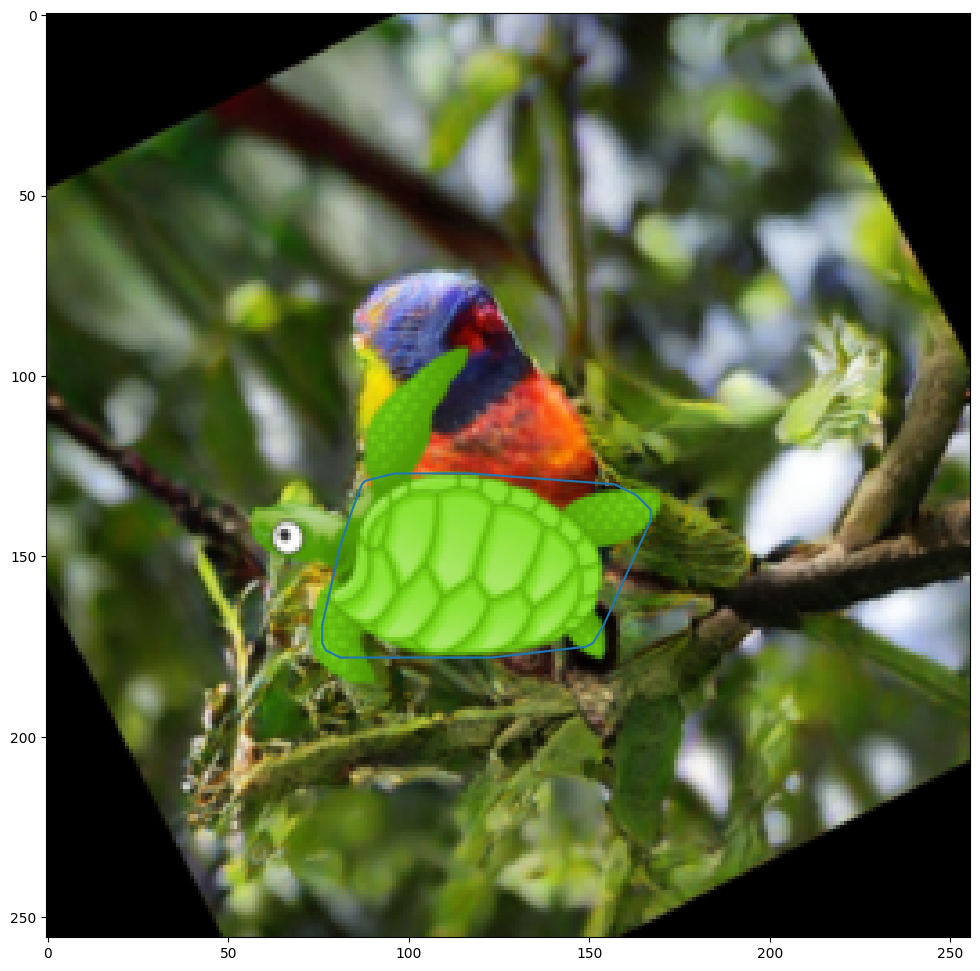

In [ ]:
class Point(object):
	def __init__(self, x, y):
		self.x = x
		self.y = y

def nextToTop(S):
	a = S.pop()
	b = S.pop()
	S.append(a)
	return b

def swap(p1, p2):
	return p2, p1

def distSq(p1, p2):
	return (p1.x - p2.x) * (p1.x - p2.x) + (p1.y - p2.y) * (p1.y - p2.y)

def orientation(p, q, r):
	val = (q.y - p.y) * (r.x - q.x) - (q.x - p.x) * (r.y - q.y)

	if (val == 0):
		return 0 # collinear
	elif (val > 0):
		return 1 # clock or wise
	else:
		return 2 # counterclock or wise


def convexHull(points, n):

  if (n < 3):
    return

  hull = []

  l = 0
  for i in range(1, n):
    if (points[i].x < points[l].x):
      l = i

  p = l
  q = 0
  while (True):

    hull.append(points[p])

    q = (p + 1) % n

    for i in range(0, n):

      if (orientation(points[p], points[i], points[q]) == 2):
        q = i

    p = q

    if (p == l):
      break

  return hull

def distSq(p1, p2):
	return (p1.x - p2.x) * (p1.x - p2.x) + (p1.y - p2.y) * (p1.y - p2.y)


def get_tight_polygon_from_mask(test_mask):
    mask_points_n2 = torch.stack(torch.where(test_mask == 1), 1)
    points = [Point(x.item(), y.item()) for y, x in mask_points_n2]  # Note: (y, x) because of tensor indexing
    n = len(points)

    hull_points = convexHull(points, n)

    hull_tensor = torch.tensor([(p.y, p.x) for p in hull_points], dtype=torch.float32)
    print(hull_tensor[0], type(hull_tensor[0]))

    return hull_tensor

def visualize_polygon_on_image(test_image, polygon_points_n2):
  # append first point to close the figure
  polygon_points_n2 = torch.cat([polygon_points_n2, polygon_points_n2[:1]], 0)
  ys, xs = torch.split(polygon_points_n2, 1, dim=-1)
  plt.figure(figsize=(12, 12))
  plt.imshow(test_image.numpy().squeeze().transpose(1, 2, 0))
  plt.plot(xs.numpy(), ys.numpy())


polygon_points_n2_tensor = get_tight_polygon_from_mask(test_mask_tensor)
visualize_polygon_on_image(test_image_tensor, polygon_points_n2_tensor)

# Task 3 : Calculating the area of the polygon
*This is where you need to implement your area calculation algorithm. You are not allowed to use cv2, scikit-image or other libraries' functionality that readily solve this task. Once again, treat this problem as a point-based rather than the image-based one.*

*You don't have to use PyTorch for this part. Your approach should output a result at the native 512x512 resolution of the test image.*

In [ ]:
def calculate_polygon_area(polygon_points_n2):

    X, Y = [], []

    for point in polygon_points_n2:
        X.append(point[0].item())
        Y.append(point[1].item())
    n = len(X)
    area = 0.0

    j = n - 1
    for i in range(0,n):
        area += (X[j] + X[i]) * (Y[j] - Y[i])
        j = i

    # Return absolute value
    return int(abs(area / 2.0))
print("Area = {:.4f}".format(calculate_polygon_area(polygon_points_n2_tensor)))

lskdj tensor([[169.,  76.],
        [147.,  81.],
        [138.,  84.],
        [130.,  87.],
        [129.,  88.],
        [127.,  96.],
        [127.,  97.],
        [127.,  98.],
        [127.,  99.],
        [127., 100.],
        [127., 101.],
        [127., 102.],
        [127., 103.],
        [127., 104.],
        [127., 105.],
        [127., 106.],
        [127., 107.],
        [127., 108.],
        [127., 109.],
        [127., 110.],
        [127., 111.],
        [127., 112.],
        [127., 113.],
        [127., 114.],
        [127., 115.],
        [127., 116.],
        [127., 117.],
        [130., 157.],
        [131., 159.],
        [132., 161.],
        [133., 163.],
        [134., 164.],
        [135., 165.],
        [136., 166.],
        [137., 167.],
        [138., 167.],
        [139., 167.],
        [140., 167.],
        [169., 154.],
        [174., 151.],
        [175., 149.],
        [178., 123.],
        [178.,  81.],
        [176.,  77.],
        [174.,  76.]])
X: 